In [7]:
!python -V

Python 3.9.19


# Intro

In [8]:
import pandas as pd

In [9]:
import pickle

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [12]:
# reading green tripdata parquet file
df_green = pd.read_parquet('data/green_tripdata_2021-01.parquet')
df_green.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76518 non-null  int64         
 1   lpep_pickup_datetime   76518 non-null  datetime64[us]
 2   lpep_dropoff_datetime  76518 non-null  datetime64[us]
 3   store_and_fwd_flag     40471 non-null  object        
 4   RatecodeID             40471 non-null  float64       
 5   PULocationID           76518 non-null  int64         
 6   DOLocationID           76518 non-null  int64         
 7   passenger_count        40471 non-null  float64       
 8   trip_distance          76518 non-null  float64       
 9   fare_amount            76518 non-null  float64       
 10  extra                  76518 non-null  float64       
 11  mta_tax                76518 non-null  float64       
 12  tip_amount             76518 non-null  float64       
 13  t

In [13]:
# reading green tripdata parquet file
df = pd.read_parquet('data/green_tripdata_2021-01.parquet')

# create new column of duration (in minutes)
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

# filter duration of 1-60 minutes
df = df[(df.duration >= 1) & (df.duration <= 60)]

# feature selection
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [14]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.5,0.96,0.00,None,0.3,5.76,1.0,1.0,0.00,2.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


In [15]:
# one hot encoding
train_dicts = df[categorical + numerical].to_dict(orient='records')

# dictionary vectorizer
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

# select target variable
target = 'duration'
y_train = df[target].values

# train model
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict
y_pred = lr.predict(X_train)

# evaluate
mean_squared_error(y_train, y_pred, squared=False)

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829628

/tmp/ipykernel_13515/329956811.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_13515/329956811.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


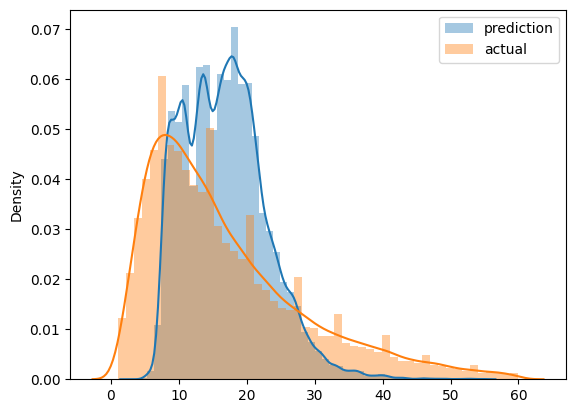

In [16]:
# visualize
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [17]:
# restructure above code into function
# read taxidata function
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [18]:
df_train = read_dataframe('data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('data/green_tripdata_2021-02.parquet')

In [19]:
len(df_train), len(df_val)

(73908, 61921)

In [20]:
# add more features to the model
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [21]:
# model evaluation
categorical = ['PU_DO'] #, 'PULocationID', 'DOLocationID'
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [22]:
# model validation
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [26]:
# experiments with linear regression
with mlflow.start_run(run_name='linear-regression'):
    mlflow.set_tag('developer', 'sur')

    mlflow.log_param('train-data-path', 'data/green_tripdata_2021-01.parquet')
    mlflow.log_param('val-data-path', 'data/green_tripdata_2021-02.parquet')

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)

    mlflow.log_metric('rmse', rmse)


    # save model to artifact
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="model")

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [24]:
# export model
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [38]:
# experiments with lasso
with mlflow.start_run(run_name='lasso'):
    mlflow.set_tag('developer', 'sur')

    mlflow.log_param('train-data-path', 'data/green_tripdata_2021-01.parquet')
    mlflow.log_param('val-data-path', 'data/green_tripdata_2021-02.parquet')

    alpha = 0.001
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)

    mlflow.log_param('alpha', alpha)
    mlflow.log_metric('rmse', rmse)

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [39]:
# experiments with Ridge
lr = Ridge()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.703735100391448

# Adding hyperparameter tuning into notebook using hyperopt

In [6]:
# Import and Setting MLflow
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.sqlite")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1716223301495, experiment_id='1', last_update_time=1716223301495, lifecycle_stage='active', name='nyc-taxi-experiment', tags={'mlflow.sharedViewState.e31aa1ce2b02e7d81ceb01f70a740b54eccfaee8b5f4899734d183517e56d5af': '{"searchFilter":"tags.model '
                                                                                            '= '
                                                                                            '\\"xgboost\\"","orderByKey":"attributes.start_time","orderByAsc":false,"startTime":"ALL","lifecycleFilter":"Active","datasetsFilter":[],"modelVersionFilter":"All '
                                                                                            'Runs","selectedColumns":["attributes.`Source`","attributes.`Models`","attributes.`Dataset`","metrics.`rmse`","params.`alpha`","params.`train-data-path`","params.`val-data-path`","tags.`developer`"],

In [29]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [30]:
# set train and validation data for xgboost
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [31]:
# Defining objective function
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
# Defining search space
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

# Passing information to fmin optimization method
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

In [33]:
# Running experiments without logging (default is automatically logging)
mlflow.xgboost.autolog(disable=True)

# Training a new model with obtained parameter
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        "learning_rate": 0.13367903342989526,
        "max_depth": 34,
        "min_child_weight": 1.998245345730752,
        "objective": "reg:linear",
        "reg_alpha": 0.006803350232023745,
        "reg_lambda": 0.10879305932743405,
        "seed": 42
    }

    # logging best parameters
    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    # logging preprocessor
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    # logging model
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:00:57] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.14534
[1]	validation-rmse:10.26384
[2]	validation-rmse:9.53935
[3]	validation-rmse:8.95173
[4]	validation-rmse:8.47317
[5]	validation-rmse:8.09067
[6]	validation-rmse:7.78492
[7]	validation-rmse:7.53894
[8]	validation-rmse:7.34385
[9]	validation-rmse:7.18601
[10]	validation-rmse:7.06155
[11]	validation-rmse:6.96266
[12]	validation-rmse:6.88255
[13]	validation-rmse:6.81814
[14]	validation-rmse:6.76640
[15]	validation-rmse:6.72498
[16]	validation-rmse:6.68869
[17]	validation-rmse:6.65976
[18]	validation-rmse:6.63516
[19]	validation-rmse:6.61415
[20]	validation-rmse:6.59620
[21]	validation-rmse:6.58176
[22]	validation-rmse:6.57002
[23]	validation-rmse:6.56026
[24]	validation-rmse:6.55068
[25]	validation-rmse:6.54248
[26]	validation-rmse:6.53647
[27]	validation-rmse:6.53066
[28]	validation-rmse:6.52633
[29]	validation-rmse:6.52227
[30]	validation-rmse:6.51813
[31]	validation-rmse:6.51454
[32]	validation-rmse:6.51146
[33]	validation-rmse:6.50950
[34]	validation-rmse:6

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:02:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [ ]:
# Making predictions using information from MLflow artifact
import mlflow
logged_model = 'runs:/5ec15f2338794a95b5b774409568af2e/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(pd.DataFrame(data))